# decappingQuantification3_allGenes.ipynb
## Marcus Viscardi,    July 18, 2024

Check out `README.md` for a more overarching view of what is happening here.

This script is taking items from both `decappingQuantification.ipynb` and `decappingQuantification2_metaPlots.ipynb` and trying to combine them into a single script that can be run on all genes. This should give us an opportunity to see the general trends in decapping efficiency across all genes and see if there are any interesting patterns that emerge.

The initial pass will just be with wildtype libraries. I can add NMD-mutants afterwards if it seems like it would be useful.

In [61]:
from typing import Tuple

import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

import re

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from pathlib import Path

from scipy.stats import mannwhitneyu, ks_2samp

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-08-19 14:14:10 | > 'Imports done!'


In [62]:
gtf_parquet_path = Path("/data16/marcus/genomes/plus_cerENO2_elegansRelease100/230327_allChrs_plus-cerENO2.gtf.parquet")

gtf_df = pd.read_parquet(gtf_parquet_path)

current_dir = Path.cwd()

In [63]:
obj_dict = {}
pretty_name_map = {
    ### The classics:
    # "oldN2": "Wildtype (rep1)",
    # "oldS6": "<i>smg-6</i> (rep1)",
    ### The terrible second replicates:
    # "newN2": "Wildtype (bad rep)",
    # "newS5": "<i>smg-5</i> (bad rep)",
    # "newS6": "<i>smg-6</i> (bad rep)",
    ### The "better" second replicates:
    "newerN2": "Wildtype (rep2)",
    "newerS6": "<i>smg-6</i> (rep2)",
    "newerS5": "<i>smg-5</i> (rep2)",
    ### The triplicates!
    "thirdN2": "Wildtype (rep3)",
    "thirdS5": "<i>smg-5</i> (rep3)",
    "thirdS6": "<i>smg-6</i> (rep3)",
    ### At 25C for smg-7 (and fourth replicates in a way):
    # "temp25cN2": "Wildtype (25°C)",
    # "temp25cS5": "<i>smg-5</i> (25°C)",
    # "temp25cS6": "<i>smg-6</i> (25°C)",
    # "temp25cS7": "<i>smg-7</i> (25°C)",
}
libs_to_run = list(pretty_name_map.keys())
for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib)
    obj_dict[lib] = obj
    obj.load_mergedOnReads()
    # obj.load_nmd_targets(return_sambamobj=False)
    print(" Done!")


Loading newerN2...Loading 230327_mergedOnReads.plusStandards.parquet... Done. Loaded 1,053,185 rows.
 Done!

Loading newerS6...Loading 230403_mergedOnReads.plusStandards.parquet... Done. Loaded 1,226,144 rows.
 Done!

Loading newerS5...Loading 230410_mergedOnReads.plusStandards.parquet... Done. Loaded 557,991 rows.
 Done!

Loading thirdN2...Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,186,602 rows.
 Done!

Loading thirdS5...Loading 230920_mergedOnReads.plusStandards.parquet... Done. Loaded 1,440,373 rows.
 Done!

Loading thirdS6...Loading 230918_mergedOnReads.plusStandards.parquet... Done. Loaded 560,899 rows.
 Done!


In [64]:
# genes = [
#     'rps-22',
#     'ubl-1',
#     'rpl-30',
#     # 'eef-1A.1',  # rev  # Something weird is going on...
#     'rla-1',  # rev
#     'rps-25',  # rev
#     'Y37E3.8',  # rev
#     'rpl-10',
#     'rla-0',
#     'rpl-18',
#     'rps-3',
#     'rpl-38',
#     'rpl-24.1',
#     'hel-1',
#     'rpl-7A',
#     'ZK228.4',
#     'R06C1.4',
#     'rpl-12',
#     'pqn-70',
#     'rsp-5',
#     'rpl-1',
#     'C53H9.2',
#     'rpl-3',
#     'rsp-6',
#     'rpl-26',
#     'K08D12.3',
#     'aly-3',
# ]
# plot_genes = genes[:]
plot_genes = gtf_df.query('feature == "gene"').gene_name.unique()
gene_ids_to_names_dict = gtf_df.query('feature == "gene"').set_index('gene_id')['gene_name'].to_dict()
gene_names_to_ids_dict = gtf_df.query('feature == "gene"').set_index('gene_name')['gene_id'].to_dict()
for gene_name in plot_genes:
    gene_id = gene_names_to_ids_dict[gene_name]
    print(f"{gene_name:>10} -> {gene_id}")
gene_ids = [gene_names_to_ids_dict[gene_name] for gene_name in plot_genes]

  cTel3X.2 -> WBGene00197333
  cTel3X.3 -> WBGene00198386
   B0348.5 -> WBGene00015153
     ife-3 -> WBGene00002061
  B0348.10 -> WBGene00255704
   B0348.9 -> WBGene00235314
     egl-8 -> WBGene00001177
21ur-15398 -> WBGene00169236
   B0348.8 -> WBGene00219784
   B0348.2 -> WBGene00015152
   B0348.1 -> WBGene00015151
    srt-52 -> WBGene00021413
  cyp-29A3 -> WBGene00021412
  Y38C9B.3 -> WBGene00021414
    daam-1 -> WBGene00018976
  F56E10.6 -> WBGene00199654
  F56E10.7 -> WBGene00200227
21ur-15058 -> WBGene00169451
    rps-27 -> WBGene00004496
  F56E10.1 -> WBGene00018975
     cgp-1 -> WBGene00000480
   W03F9.1 -> WBGene00020999
   W03F9.2 -> WBGene00021000
    sftb-2 -> WBGene00021004
   W03F9.3 -> WBGene00021001
  W03F9.11 -> WBGene00044512
   W03F9.9 -> WBGene00021003
   W03F9.8 -> WBGene00023356
    srh-81 -> WBGene00005302
21ur-13870 -> WBGene00170056
    srh-82 -> WBGene00005303
   W03F9.4 -> WBGene00021002
     ttb-1 -> WBGene00006648
   cfap-36 -> WBGene00022435
Y108G3AL.2 -> 

In [65]:
import pysam

In [66]:
UNANNOTATED_TSS_DICT = {  # these are manual annotations of transcription start sites that are not in the GTF file
    'rpl-7A': [4_390_579, 4_390_464],
}

UNANNOTATED_STOPS_DICT = {  # these are manual annotations of stops that are not in the GTF file
    'rps-22': [1_950_853],  # cassette exon contains PTC
    'rpl-30': [10_436_332],  # extension of first exon contains PTC
    'rpl-7A': [4_389_880, 4_389_745],  # unannotated extension of 3rd exon contains PTC (second loc due to potential FS)
    'rsp-6': [7_790_576],  # longer unannotated form of cassette exon causes frame shift
    'C53H9.2': [1_833_467],  # shorter first exon leaves frame shift
    'pqn-70': [11_226_879],  # skipped exon leads to a frame change
    'rpl-1': [2_875_908],  # new orf started in the 3' extension of the first exon, causing a frame change
    'R06C1.4': [11_931_081],  # unannotated cassette exon contains a frame shift
    'rpl-3': [3_868_335],  # incorrectly annotated first intron 3' truncation (2nd exon extended) contains stop
    'hel-2': [8_327_970],  # later 5' SS adds to 3rd exon and contains PTC
    'rpl-12': [13_240_078],  # later 5' SS of second intron adds extension to 2nd exon with a PTC
    'aly-3': [12_123_859], # huge extension of second exon contains as PTC
}

def get_other_read_end(row):
    cigar = row['cigar']
    read_pos = row['chr_pos']
    if cigar is None:
        raise ValueError("Cigar is None!")
    if read_pos is None:
        raise ValueError("read_pos is None!")
    pattern = r"(\d*)([MDISN])"
    matches = re.findall(pattern, cigar)
    for match in matches:
        count, key = match
        if key in ['M', 'D', 'N']:
            read_pos += int(count)
    return read_pos

def near_a_tss(row, _strand, tss_positions, col_for_pos='chr_pos', full_window_size=50, window_bias_downstream=0.50, make_window_correction=True) -> Tuple[bool, bool]:
    chr_pos = row[col_for_pos]
    if _strand == '-' and make_window_correction:
        window_bias_downstream = 1 - window_bias_downstream
    elif _strand != '+' and make_window_correction:
        raise ValueError(f"Strand must be '+' or '-' not {_strand}")
    
    near_tss = False
    chr_pos_upstream = chr_pos - full_window_size * (1 - window_bias_downstream)
    chr_pos_downstream = chr_pos + full_window_size * window_bias_downstream
    for tss in set(tss_positions):
        if chr_pos_upstream <= tss <= chr_pos_downstream:
            near_tss = True
            break
    return near_tss

# TODO: Rework the following to be more efficient!
def just_extract_gene_data(gtf_df, test_gene, plot_lib_df_dict, window_size=100,
                           up_v_down_fraction=0.25, print_stats=False):    
    # extra_stops_dict = UNANNOTATED_STOPS_DICT
    extra_tss_dict = UNANNOTATED_TSS_DICT
    
    gtf_for_gene = gtf_df.query("gene_name == @test_gene")
    gene_start, gene_end = gtf_for_gene.query("feature == 'gene'").loc[:, ['start', 'end']].values[0]
    gene_length = gene_end - gene_start
    
    strand = gtf_for_gene.query("feature == 'gene'").loc[:, 'strand'].values[0]
    if print_stats:
        print(f"Gene target ({test_gene}) on strand: {strand}")
    if strand == '-':
        if print_stats:
            print("Because this gene is on the reverse strand, we will have to calculate out the other end of the reads with the CIGAR strings. This will take slightly longer.")
        # stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'end'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'end'].values
        up_v_down_fraction = 1 - up_v_down_fraction
        flipped = True
    else:
        # stop_locations = gtf_for_gene.query("feature == 'stop_codon'").loc[:, 'start'].values
        start_sites = gtf_for_gene.query("feature == 'transcript'").loc[:, 'start'].values
        flipped = False
        
    # stop_locations = list(stop_locations)
    start_sites = list(start_sites)
    
    # if test_gene in extra_stops_dict:
    #     for stop_location in extra_stops_dict[test_gene]:
    #         stop_locations.append(stop_location)
    if test_gene in extra_tss_dict:
        for tss_location in extra_tss_dict[test_gene]:
            start_sites.append(tss_location)
    summary_dict_for_gene = {}
    for i, (lib, lib_df) in enumerate(plot_lib_df_dict.items()):

        if print_stats:
            print(f"\t{lib}:")
        
        gene_df = lib_df.query('gene_name == @test_gene').copy()
        gene_df.replace({'t5': {0: '-', 1: '+', '+': '+', '-': '-'}}, inplace=True)
        if flipped:
            gene_df.loc[:, 'chr_pos'] = gene_df.apply(get_other_read_end, axis=1)
        gene_df.loc[:, 'near_tss'] = gene_df.apply(near_a_tss, args=(strand, start_sites),
            full_window_size=window_size,window_bias_downstream=up_v_down_fraction, axis=1)
        
        unadapted_df = gene_df.query('t5 == "-"').copy()
        adapted_df = gene_df.query('t5 == "+"').copy()
        
        ada_near_tss_count = adapted_df.query('near_tss').shape[0]
        unada_near_tss_count = unadapted_df.query('near_tss').shape[0]
        ada_total_count = adapted_df.shape[0]
        unada_total_count = unadapted_df.shape[0]
        summary_dict_for_gene[lib] = {
            # 'Adapted Near Stop': ada_near_stop_count,
            'Adapted Near TSS': ada_near_tss_count,
            'Total Adapted': ada_total_count,
            # 'Unadapted Near Stop': unada_near_stop_count,
            'Unadapted Near TSS': unada_near_tss_count,
            'Total Unadapted': unada_total_count,
            'Gene Length': gene_length,
        }
    return summary_dict_for_gene


plot_libs = [
    ### The classics:
    #"oldN2",
    # "oldS6",
    ### The terrible second replicates:
    # "newN2",
    # "newS5",
    # "newS6",
    ### The "better" second replicates:
    "newerN2",
    "newerS6",
    "newerS5",
    ### The triplicates!
    "thirdN2",
    "thirdS5",
    "thirdS6",
    ### At 25C for smg-7 (and fourth replicates in a way):
    # "temp25cN2",
    # "temp25cS5",
    # "temp25cS6",
    # "temp25cS7",
    
]
window_size_for_search = 100  # 100nt seems to make sense (+50 and -50 from the TSS or STOP)

plot_lib_objs_dict = {lib: obj_dict[lib] for lib in plot_libs}
overall_summaries_nested_dict = {}
subset_nmd_types_name, subset_nmd_types = 'indifferent', 'indifferent'
for gene in tqdm(plot_genes[:]):
    # print(f"{gene:-^50}")
    gene_summary_dicts = {}
    try:
        lib_df_dict_for_gene = {lib: lib_obj.mergedOnReads_df.query('gene_name == @gene')
                                for lib, lib_obj in plot_lib_objs_dict.items()}
        summary_dict = just_extract_gene_data(gtf_df, gene, lib_df_dict_for_gene, print_stats=False, window_size=window_size_for_search)
        gene_summary_dicts[subset_nmd_types_name] = summary_dict
    except Exception as e:
        print(f"Error: {e}")
        print(f"Gene: {gene}")
        # print(f"Continuing...")
        raise e
    overall_summaries_nested_dict[gene] = gene_summary_dicts
plotting_list_for_df = []

dict_index = 0
for gene, gene_dict in tqdm(overall_summaries_nested_dict.items()):
    for nmd_target_type, target_type_dict in gene_dict.items():
        print(f"{gene} ({nmd_target_type}):")
        for lib, lib_dict in target_type_dict.items():
            # print(f"\t{lib}:")
            # # print(f"\t\tAdapted Near Stop:   {lib_dict['Adapted Near Stop']}")
            # print(f"\t\tAdapted Near TSS:    {lib_dict['Adapted Near TSS']}")
            # print(f"\t\tTotal Adapted:       {lib_dict['Total Adapted']}")
            # # print(f"\t\tUnadapted Near Stop: {lib_dict['Unadapted Near Stop']}")
            # print(f"\t\tUnadapted Near TSS:  {lib_dict['Unadapted Near TSS']}")
            # print(f"\t\tTotal Unadapted:     {lib_dict['Total Unadapted']}")
            # try:
            #     print(f"\t\tAda Stop/Unada FL: {lib_dict['Adapted Near Stop']/lib_dict['Unadapted Near TSS']:.2%}")
            # except ZeroDivisionError:
            #     print(f"\t\tAda Stop/Unada FL: -- NO UNADAPTED FL --")
            plotting_list_for_df.append(
                {
                    'gene_name': gene,
                    'gene_length': lib_dict['Gene Length'],
                    'nmd_target_type': nmd_target_type,
                    'lib': lib,
                    # 'adapted_near_stop': lib_dict['Adapted Near Stop'],
                    'adapted_near_tss': lib_dict['Adapted Near TSS'],
                    'total_adapted': lib_dict['Total Adapted'],
                    # 'unadapted_near_stop': lib_dict['Unadapted Near Stop'],
                    'unadapted_near_tss': lib_dict['Unadapted Near TSS'],
                    'total_unadapted': lib_dict['Total Unadapted'],
                }
            )

plotting_summary_df = pd.DataFrame.from_records(plotting_list_for_df)
plotting_summary_df

  0%|          | 0/46905 [00:00<?, ?it/s]

  0%|          | 0/46905 [00:00<?, ?it/s]

cTel3X.2 (indifferent):
cTel3X.3 (indifferent):
B0348.5 (indifferent):
ife-3 (indifferent):
B0348.10 (indifferent):
B0348.9 (indifferent):
egl-8 (indifferent):
21ur-15398 (indifferent):
B0348.8 (indifferent):
B0348.2 (indifferent):
B0348.1 (indifferent):
srt-52 (indifferent):
cyp-29A3 (indifferent):
Y38C9B.3 (indifferent):
daam-1 (indifferent):
F56E10.6 (indifferent):
F56E10.7 (indifferent):
21ur-15058 (indifferent):
rps-27 (indifferent):
F56E10.1 (indifferent):
cgp-1 (indifferent):
W03F9.1 (indifferent):
W03F9.2 (indifferent):
sftb-2 (indifferent):
W03F9.3 (indifferent):
W03F9.11 (indifferent):
W03F9.9 (indifferent):
W03F9.8 (indifferent):
srh-81 (indifferent):
21ur-13870 (indifferent):
srh-82 (indifferent):
W03F9.4 (indifferent):
ttb-1 (indifferent):
cfap-36 (indifferent):
Y108G3AL.2 (indifferent):
Y108G3AL.10 (indifferent):
Y108G3AL.8 (indifferent):
Y108G3AL.9 (indifferent):
cul-3 (indifferent):
arid-1 (indifferent):
trpp-1 (indifferent):
lec-12 (indifferent):
DC2.5 (indifferent):
s

,gene_name,gene_length,nmd_target_type,lib,adapted_near_tss,total_adapted,unadapted_near_tss,total_unadapted
0,cTel3X.2,149,indifferent,newerN2,0,0,0,0
1,cTel3X.2,149,indifferent,newerS6,0,0,0,0
2,cTel3X.2,149,indifferent,newerS5,0,0,0,0
3,cTel3X.2,149,indifferent,thirdN2,0,0,0,0
4,cTel3X.2,149,indifferent,thirdS5,0,0,0,0
...,...,...,...,...,...,...,...,...
281425,cerENO2,661,indifferent,newerS6,0,0,0,0
281426,cerENO2,661,indifferent,newerS5,0,0,0,0
281427,cerENO2,661,indifferent,thirdN2,0,0,0,0
281428,cerENO2,661,indifferent,thirdS5,0,0,0,0


In [67]:
# Before anything let's copy down code so we can regenerate the input df
summary_df = plotting_summary_df.copy()

lib_strain_dict = {'N2': 'wildtype',
                   'S5': 'smg-5',
                   'S6': 'smg-6',
                   'S7': 'smg-7'}

summary_df['strain'] = summary_df.lib.str[-2:].map(lib_strain_dict)

summary_df['total_near_tss'] = summary_df['adapted_near_tss'] + summary_df['unadapted_near_tss']
# summary_df['total_near_stop'] = summary_df['adapted_near_stop'] + summary_df['unadapted_near_stop']
summary_df['total_reads'] = summary_df['total_adapted'] + summary_df['total_unadapted']

# # There are a few different ways to do this!
# summary_df['frac_near_tss'] = summary_df['total_near_tss'] / summary_df['total_reads']
# 
# summary_df['frac_near_tss'] = summary_df['adapted_near_tss'] / summary_df['total_reads']

summary_df

,gene_name,gene_length,nmd_target_type,lib,adapted_near_tss,total_adapted,unadapted_near_tss,total_unadapted,strain,total_near_tss,total_reads
0,cTel3X.2,149,indifferent,newerN2,0,0,0,0,wildtype,0,0
1,cTel3X.2,149,indifferent,newerS6,0,0,0,0,smg-6,0,0
2,cTel3X.2,149,indifferent,newerS5,0,0,0,0,smg-5,0,0
3,cTel3X.2,149,indifferent,thirdN2,0,0,0,0,wildtype,0,0
4,cTel3X.2,149,indifferent,thirdS5,0,0,0,0,smg-5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
281425,cerENO2,661,indifferent,newerS6,0,0,0,0,smg-6,0,0
281426,cerENO2,661,indifferent,newerS5,0,0,0,0,smg-5,0,0
281427,cerENO2,661,indifferent,thirdN2,0,0,0,0,wildtype,0,0
281428,cerENO2,661,indifferent,thirdS5,0,0,0,0,smg-5,0,0


In [68]:
import scipy.stats as stats
from colorama import Fore, Style

def run_stats_intralib(df_in, compare_col, sig_cutoff=0.05, steps=[100, 10, 1],
                       strains=('wildtype', 'smg-5', 'smg-6'),
                       output_file: Path = None):
    test_results = {}
    output_string = ""
    for strain in strains:
        nmd_df = df_in.query("strain == @strain & nmd_target_type == 'NMD_Targets'")
        non_nmd_df = df_in.query("strain == @strain & nmd_target_type == 'NMD_NonTargets'")
        merge_df = nmd_df.merge(non_nmd_df,
                                on=('gene_name', 'strain', 'rep', 'lib', 'name'),
                                suffixes=('_nmd', '_non_nmd'))
        paired_test = stats.ttest_rel(merge_df[f'{compare_col}_nmd'], merge_df[f'{compare_col}_non_nmd'])
        unpaired_test = stats.ttest_ind(nmd_df[compare_col], non_nmd_df[compare_col])
        test_results[strain] = {'paired': paired_test, 'unpaired': unpaired_test}
    output_string += f"{'Strain':^8} | {'Paired p-val (df)':^15} | {'Unpaired p-val (df)':^15}\n"
    output_string += '-' * 50 + '\n'
    for strain, test_dict in test_results.items():
        paired_str = f" {test_dict['paired'].pvalue:^1.3e}   ({test_dict['paired'].df:>2})"
        unpaired_str = f"   {test_dict['unpaired'].pvalue:^1.3e}   ({int(test_dict['unpaired'].df):>2})"
        if test_dict['paired'].pvalue < sig_cutoff / steps[0]:
            paired_str = Fore.MAGENTA + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[1]:
            paired_str = Fore.RED + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[2]:
            paired_str = Fore.YELLOW + paired_str + Style.RESET_ALL
        if test_dict['unpaired'].pvalue < sig_cutoff / steps[0]:
            unpaired_str = Fore.MAGENTA + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[1]:
            unpaired_str = Fore.RED + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[2]:
            unpaired_str = Fore.YELLOW + unpaired_str + Style.RESET_ALL
        output_string += f"{strain:>8} | {paired_str} | {unpaired_str}\n"
    key_string = (f"Key: "
                  f"{Fore.MAGENTA}p < {sig_cutoff / steps[0]}{Style.RESET_ALL} "
                  f"{Fore.RED}p < {sig_cutoff / steps[1]}{Style.RESET_ALL} "
                  f"{Fore.YELLOW}p < {sig_cutoff / steps[2]}{Style.RESET_ALL}\n")
    print(output_string + key_string)
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    output_string = ansi_escape.sub('', output_string)
    if output_file is not None:
        with open(output_file, 'a') as f:
            f.write(output_string)
    return output_string

def run_stats_interlib(df_in, compare_col, sig_cutoff=0.05, steps=[100, 10, 1],
                       comparisons=(('wildtype', 'smg-5'), ('wildtype', 'smg-6'), ('smg-5', 'smg-6')),
                       nmd_type='NMD_NonTargets',
                       output_file=None):
    # Now let's do a similar comparison but between non-NMD-targets between libs
    test_results = {}
    output_string = ""
    for comp in comparisons:
        nmd_df = df_in.query("strain == @comp[0] & nmd_target_type == @nmd_type")
        non_nmd_df = df_in.query("strain == @comp[1] & nmd_target_type == @nmd_type")
        drop_cols = ['nmd_target_type', 'strain', 'lib', 'name']
        merge_df = nmd_df.drop(columns=drop_cols).merge(non_nmd_df.drop(columns=drop_cols), on=('gene_name', 'rep'), suffixes=('_lib1', '_lib2'))
        paired_test = stats.ttest_rel(merge_df[f'{compare_col}_lib1'], merge_df[f'{compare_col}_lib2'])
        unpaired_test = stats.ttest_ind(nmd_df[compare_col], non_nmd_df[compare_col])
        test_results[comp] = {'paired': paired_test, 'unpaired': unpaired_test}
    
    output_string += f"{'Comp':^14} | {'Paired p-val (df)':^15} | {'Unpaired p-val (df)':^15}\n"
    output_string += '-'*56 + '\n'
    
    for (lib1, lib2), test_dict in test_results.items():
        paired_str = f" {test_dict['paired'].pvalue:^1.3e}   ({test_dict['paired'].df:>2})"
        unpaired_str = f"   {test_dict['unpaired'].pvalue:^1.3e}   ({int(test_dict['unpaired'].df):>2})"
        if lib1 == 'wildtype':
            lib1 = 'wt'
        if test_dict['paired'].pvalue < sig_cutoff / steps[0]:
            paired_str = Fore.MAGENTA + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[1]:
            paired_str = Fore.RED + paired_str + Style.RESET_ALL
        elif test_dict['paired'].pvalue < sig_cutoff / steps[2]:
            paired_str = Fore.YELLOW + paired_str + Style.RESET_ALL
        if test_dict['unpaired'].pvalue < sig_cutoff / steps[0]:
            unpaired_str = Fore.MAGENTA + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[1]:
            unpaired_str = Fore.RED + unpaired_str + Style.RESET_ALL
        elif test_dict['unpaired'].pvalue < sig_cutoff / steps[2]:
            unpaired_str = Fore.YELLOW + unpaired_str + Style.RESET_ALL
        output_string += f"{lib1:>5} vs {lib2:<5} | {paired_str} | {unpaired_str}\n"
    key_string = (f"Key: "
                  f"{Fore.MAGENTA}p < {sig_cutoff / steps[0]}{Style.RESET_ALL} "
                  f"{Fore.RED}p < {sig_cutoff / steps[1]}{Style.RESET_ALL} "
                  f"{Fore.YELLOW}p < {sig_cutoff / steps[2]}{Style.RESET_ALL}\n")
    print(output_string + key_string)
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    output_string = ansi_escape.sub('', output_string)
    if output_file is not None:
        with open(output_file, 'a') as f:
            f.write(output_string)
    return output_string

In [69]:
# Maybe the NMD targets have higher adapted_TSS fractions in the WT not because they have high numbers of adapted_TSS reads, but b/c they have lower numbers of the denominator (all reads)
# To remedy this, let's try comparing the adapted_TSS to the unadapted_TSS

# Additionally, it would be nice to do an adapted RPM comparison against Adapt TSS reads. But this needs more reads!!

# I need to circle WAY back to retain both adapt and unadapted TSSes.. UGH LETS DO IT
in_df = summary_df.copy()
set_dict = {'old': 1, 'newer': 2, 'third': 3, 'temp25c': 4}

in_df['rep'] = in_df.lib.str[:-2].map(set_dict)
in_df = in_df.set_index(['gene_name', 'strain', 'rep','lib', 'nmd_target_type']).sort_index()
better_df = in_df.loc[:, :, :, :, ['indifferent'], :]
better_df

gene_length  adapted_near_tss  total_adapted  unadapted_near_tss  total_unadapted  total_near_tss  total_reads
gene_name strain   rep lib     nmd_target_type                                                                                                                
21ur-1    smg-5    2   newerS5 indifferent               20                 0              0                   0                0               0            0
                   3   thirdS5 indifferent               20                 0              0                   0                0               0            0
          smg-6    2   newerS6 indifferent               20                 0              0                   0                0               0            0
                   3   thirdS6 indifferent               20                 0              0                   0                0               0            0
          wildtype 2   newerN2 indifferent               20                 0              0                   0                0               0            0
...                                                     ...               ...            ...                 ...              ...             ...          ...
zyx-1     smg-5    3   thirdS5 indifferent            14716                 0              3                  10              109              10          112
          smg-6    2   newerS6 indifferent            14716                 0              2                   4              113               4          115
                   3   thirdS6 indifferent            14716                 0              0                   0               27               0           27
          wildtype 2   newerN2 indifferent            14716                 0              0                   8               65               8           65
                   3   thirdN2 indifferent            14716                 0              1                   7               87               7           88

[281430 rows x 7 columns]

In [70]:
min_total = 1
min_adapted = 5

def run_box_and_ttests(input_df: pd.DataFrame,
                       target_num: str, target_denom: str,
                       min_total_reads: int = 1,
                       min_adapted_reads: int = 1,
                       min_tss_ada_reads: int = 0,
                       output_dir: Path = current_dir / 'plots' / 'decapping',
                       log_y: bool = True,
                       log2_y: bool = False,
                       template: str = 'none') -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str) + ' rep' + box_df['rep'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if log2_y:
        box_df = box_df[box_df[target_col] > 0]
        box_df[f"log2({target_col})"] = np.log2(box_df[target_col])
        target_col = f"log2({target_col})"
        log_y = False
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    hover_columns = [
        'name',
        target_num,
        target_denom,
        'adapted_near_tss',
        'unadapted_near_tss',
        'total_reads',
        'total_adapted',
    ]
    
    fig = px.box(box_df,
                 x='strain',
                 y=target_col,
                 color='nmd_target_type',
                 color_discrete_map=colors_dict,
                 points='all',
                 hover_name='name',
                 log_y=log_y,
                 hover_data=set(hover_columns),
                 template=template,
                 title=f"{target_col} by Strain<br>Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}",
                 height=500,
                 width=1000,
                 )
    if target_denom == 'total_reads':
        fig.update_yaxes(title_text=f'{target_num} / <br>{target_denom}')
    else:
        fig.update_yaxes(range=[-0.1, 1.1],
                         title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(
        font=dict(
            # family="Courier New, monospace",
            size=18,
            # color="RebeccaPurple",
        ),
                 )
    fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    fig.write_html(output_dir / f"boxPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"boxPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')
    # 
    # output_file = output_dir / f'boxPlotStats_{save_friendly_target_col}.txt'
    # output_file.touch(exist_ok=True)
    # with open(output_file, 'w') as f:
    #     f.write(f"Stats for {target_col}\n")
    #     f.write("\nIntra Library Stats w/ NMD Targets:\n")
    # print("Targets")
    # run_stats_interlib(box_df, target_col, nmd_type='NMD_Targets', output_file=output_file)
    # with open(output_file, 'a') as f:
    #     f.write("\nIntra Library Stats w/ Non Targets:\n")
    # print("NonTargets")
    # run_stats_interlib(box_df, target_col, nmd_type='NMD_NonTargets', output_file=output_file)
    # 
    # with open(output_file, 'a') as f:
    #     f.write("\nInter Library Stats:\n")
    # run_stats_intralib(box_df, target_col, output_file=output_file)

def plot_xy(input_df: pd.DataFrame,
            target_num: str, target_denom: str,
            x_col: str,
            min_total_reads: int = 1,
            min_adapted_reads: int = 1,
            min_tss_ada_reads: int = 0,
            output_dir: Path = current_dir / 'plots' / 'decapping',
            log_y: bool = True,
            log_x: bool = True,
            color_by: str = 'strain',
            template: str = 'none') -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df['near_tss'] = input_df['adapted_near_tss'] + input_df['unadapted_near_tss']
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str) + ' rep' + box_df['rep'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    hover_columns = [
        'name',
        'gene_length',
        target_num,
        target_denom,
        'adapted_near_tss',
        'unadapted_near_tss',
        'total_reads',
        'total_adapted',
    ]
    
    fig = px.scatter(box_df,
                     x=x_col,
                     y=target_col,
                     color=color_by,
                     color_discrete_map=colors_dict,
                     hover_name='name',
                     log_y=log_y,
                     log_x=log_x,
                     hover_data=set(hover_columns),
                     template=template,
                     # title=f"{target_col} by Strain<br>Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}",
                     opacity=0.4,
                     height=500,
                     width=700,
                     )
    # if target_denom == 'total_reads':
    #     fig.update_yaxes(title_text=f'{target_num} / <br>{target_denom}')
    # else:
    #     fig.update_yaxes(range=[-0.1, 1.1],
    #                      title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(font=dict(size=18))
    # fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    fig.write_html(output_dir / f"boxPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"boxPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')

def run_cdf_and_ttests(input_df: pd.DataFrame,
                       target_num: str, target_denom: str,
                       min_total_reads: int = 1,
                       min_adapted_reads: int = 1,
                       min_tss_ada_reads: int = 0,
                       output_dir: Path = current_dir / 'plots' / 'decapping',
                       log_y: bool = True,
                       log2_y: bool = False,
                       template: str = 'none') -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str) + ' rep' + box_df['rep'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if log2_y:
        box_df = box_df[box_df[target_col] > 0]
        box_df[f"log2({target_col})"] = np.log2(box_df[target_col])
        target_col = f"log2({target_col})"
        log_y = False
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    fig = px.ecdf(box_df,
                 facet_col='strain',
                 x=target_col,
                 color='nmd_target_type',
                 color_discrete_map=colors_dict,
                 hover_name='name',
                 log_y=log_y,
                 hover_data=[target_num, target_denom],
                 template=template,
                 title=f"{target_col} by Strain<br>Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}",
                 # height=500,
                 # width=1000,
                 )
    fig.update_xaxes(title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(
        font=dict(
            # family="Courier New, monospace",
            size=18,
            # color="RebeccaPurple",
        ),
                 )
    # fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    save_friendly_target_col += f"_minTotal_{min_total_reads}_minAdapted_{min_adapted_reads}"
    fig.write_html(output_dir / f"cdfPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"cdfPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')
    
    output_file = output_dir / f'cdfPlotStats_{save_friendly_target_col}.txt'
    output_file.touch(exist_ok=True)
    with open(output_file, 'w') as f:
        f.write(f"Stats for {target_col}\n")
        f.write("\nIntra Library Stats w/ NMD Targets:\n")
    print("Targets")
    run_stats_interlib(box_df, target_col, nmd_type='NMD_Targets', output_file=output_file)
    with open(output_file, 'a') as f:
        f.write("\nIntra Library Stats w/ Non Targets:\n")
    print("NonTargets")
    run_stats_interlib(box_df, target_col, nmd_type='NMD_NonTargets', output_file=output_file)
    
    with open(output_file, 'a') as f:
        f.write("\nInter Library Stats:\n")
    run_stats_intralib(box_df, target_col, output_file=output_file)

def run_xy_and_ttests(input_df: pd.DataFrame,
                      target_num: str, target_denom: str,
                      min_total_reads: int = 1,
                      min_adapted_reads: int = 1,
                      min_tss_ada_reads: int = 0,
                      log_y: bool = True,
                      extra_savename: str = '',
                      output_dir: Path = current_dir / 'plots' / 'decapping',
                      template: str = 'none') -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str) + ' rep' + box_df['rep'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    fig = px.scatter(box_df,
                 x=target_num,
                 y=target_denom,
                 facet_col='strain',
                 color='nmd_target_type',
                 color_discrete_map=colors_dict,
                 hover_name='name',
                 hover_data=[target_num, target_denom],
                 template=template,
                 log_y=log_y,
                 title=f"{target_num} x {target_denom} by Strain<br>"
                       f"Min Total: {min_total_reads}, Min Adapt: {min_adapted_reads}, Min TSS Adapt: {min_tss_ada_reads}",
                 opacity=0.7,
                 )
    # fig2 = px.density_contour(box_df,
    #              x=target_num,
    #              y=target_denom,
    #              color='nmd_target_type',
    #              color_discrete_map=colors_dict,
    #              hover_name='name',
    #              hover_data=[target_num, target_denom],
    #              template=template,
    #              log_y=log_y,
    #              title=f"{target_num} x {target_denom} by Strain<br>"
    #                    f"Min Total: {min_total_reads}, Min Adapt: {min_adapted_reads}, Min TSS Adapt: {min_tss_ada_reads}",
    #              height=500,
    #              width=700,
    #              )
    # fig = go.Figure(data=fig1.data + fig2.data)
    fig.update_layout(
        font=dict(
            # family="Courier New, monospace",
            size=18,
            # color="RebeccaPurple",
        ),
                 )
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
    
    save_friendly_target_col += extra_savename
    
    fig.write_html(output_dir / f"xyPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"xyPlot_{save_friendly_target_col}.png", scale=5,
                 height=500,
                 width=700,)
    fig.show(renderer='firefox')
    
    # output_file = output_dir / f'boxPlotStats_{save_friendly_target_col}.txt'
    # output_file.touch(exist_ok=True)
    # with open(output_file, 'w') as f:
    #     f.write(f"Stats for {target_col}\n")
    #     f.write("\nIntra Library Stats w/ NMD Targets:\n")
    # print("Targets")
    # run_stats_interlib(box_df, target_col, nmd_type='NMD_Targets', output_file=output_file)
    # with open(output_file, 'a') as f:
    #     f.write("\nIntra Library Stats w/ Non Targets:\n")
    # print("NonTargets")
    # run_stats_interlib(box_df, target_col, nmd_type='NMD_NonTargets', output_file=output_file)
    # 
    # with open(output_file, 'a') as f:
    #     f.write("\nInter Library Stats:\n")
    # run_stats_intralib(box_df, target_col, output_file=output_file)

min_adapteds = [
    # 1,
    # 2, 3, 4,
    # 5,
    10,
]

target_denominators = [
    'total_reads',
    # 'unadapted_near_tss',
    # 'total_adapted',
]
for min_adapted in min_adapteds:
    for target_denominator in target_denominators:
        print(f"\n\nUsing {target_denominator=} for denominator... And {min_adapted=}...\n")
        # run_box_and_ttests(
        #     better_df, # better_df.query("strain == 'wildtype'"),
        #     'adapted_near_tss', target_denominator,
        #     min_adapted_reads=min_adapted, min_tss_ada_reads=0, log_y=False)
        # plot_xy(better_df,
        #         'near_tss', target_denominator,
        #         'gene_length',
        #         min_total_reads=1, min_adapted_reads=min_adapted, min_tss_ada_reads=0,
        #         log_y=False, log_x=True)
print("Done!")



Using target_denominator='total_reads' for denominator... And min_adapted=10...

Done!


In [71]:
# We need to produce a better gene_length information
gtf_df['genomic_length'] = gtf_df['end'] - gtf_df['start']

In [72]:
# The magic of pandas:
transcript_lengths = gtf_df.query("feature == 'exon'").groupby(['gene_name', 'gene_id', 'transcript_id'])['genomic_length'].sum()
# transcript_lengths.plot.hist(bins=100)
transcript_lengths.reset_index().query("gene_name == 'unc-54'")

,gene_name,gene_id,transcript_id,genomic_length
60603,unc-54,WBGene00006789,F11C3.3.1,6195
60604,unc-54,WBGene00006789,F11C3.3.2,6286
60605,unc-54,WBGene00006789,F11C3.3.3,6061


,gene_name,gene_id,transcript_id,genomic_length
60603,unc-54,WBGene00006789,F11C3.3.1,7581
60604,unc-54,WBGene00006789,F11C3.3.2,7672
60605,unc-54,WBGene00006789,F11C3.3.3,7552


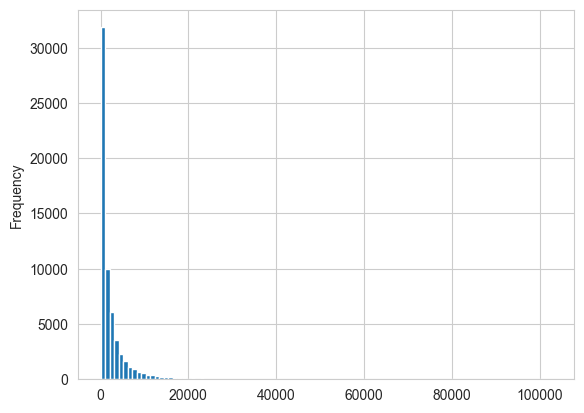

In [73]:
# The values we were using before (we actually just used the largest of these)
overal_transcript_length = gtf_df.query("feature == 'transcript'").set_index(['gene_name', 'gene_id', 'transcript_id']).sort_index()['genomic_length']
overal_transcript_length.plot.hist(bins=100)
overal_transcript_length.reset_index().query("gene_name == 'unc-54'")

In [74]:
# let's try taking the average of the transcript lengths for each gene
transcript_lengths = transcript_lengths.reset_index()
gene_lengths = transcript_lengths.groupby('gene_name')['genomic_length'].agg(['mean', 'std'])
gene_lengths.rename(columns={'mean': 'avg_transcript_length', 'std': 'std_transcript_length'}, inplace=True)
gene_lengths.fillna(0, inplace=True)
# I think a bunch of these tiny genes aren't even real.
# The requirement for reads in the library means they'll get dropped so no worries.
# gene_lengths.plot.hist(bins=100)
gene_lengths.reset_index().query("gene_name == 'unc-54'")

,gene_name,avg_transcript_length,std_transcript_length
46561,unc-54,6180.666667,113.182743


In [75]:
in_df = summary_df.copy()
set_dict = {'old': 1, 'newer': 2, 'third': 3, 'temp25c': 4}

in_df['rep'] = in_df.lib.str[:-2].map(set_dict)
in_df = in_df.set_index(['gene_name', 'strain', 'rep','lib', 'nmd_target_type']).sort_index()
better_df = in_df.loc[:, :, :, :, ['indifferent'], :]
better_df = better_df.reset_index().merge(gene_lengths.reset_index(), on='gene_name').set_index(['gene_name', 'strain', 'rep','lib', 'nmd_target_type'])
better_df

gene_length  adapted_near_tss  total_adapted  unadapted_near_tss  total_unadapted  total_near_tss  total_reads  avg_transcript_length  \
gene_name strain   rep lib     nmd_target_type                                                                                                                                          
21ur-1    smg-5    2   newerS5 indifferent               20                 0              0                   0                0               0            0                   20.0   
                   3   thirdS5 indifferent               20                 0              0                   0                0               0            0                   20.0   
          smg-6    2   newerS6 indifferent               20                 0              0                   0                0               0            0                   20.0   
                   3   thirdS6 indifferent               20                 0              0                   0                0               0            0                   20.0   
          wildtype 2   newerN2 indifferent               20                 0              0                   0                0               0            0                   20.0   
...                                                     ...               ...            ...                 ...              ...             ...          ...                    ...   
zyx-1     smg-5    3   thirdS5 indifferent            14716                 0              3                  10              109              10          112            1785.285714   
          smg-6    2   newerS6 indifferent            14716                 0              2                   4              113               4          115            1785.285714   
                   3   thirdS6 indifferent            14716                 0              0                   0               27               0           27            1785.285714   
          wildtype 2   newerN2 indifferent            14716                 0              0                   8               65               8           65            1785.285714   
                   3   thirdN2 indifferent            14716                 0              1                   7               87               7           88            1785.285714   

                                                std_transcript_length  
gene_name strain   rep lib     nmd_target_type                         
21ur-1    smg-5    2   newerS5 indifferent                        0.0  
                   3   thirdS5 indifferent                        0.0  
          smg-6    2   newerS6 indifferent                        0.0  
                   3   thirdS6 indifferent                        0.0  
          wildtype 2   newerN2 indifferent                        0.0  
...                                                               ...  
zyx-1     smg-5    3   thirdS5 indifferent                   524.6814  
          smg-6    2   newerS6 indifferent                   524.6814  
                   3   thirdS6 indifferent                   524.6814  
          wildtype 2   newerN2 indifferent                   524.6814  
                   3   thirdN2 indifferent                   524.6814  

[281430 rows x 9 columns]

In [81]:
genes = [
    'rps-22',
    'ubl-1',
    'rpl-30',
    # 'eef-1A.1',  # rev  # Something weird is going on...
    'rla-1',  # rev
    'rps-25',  # rev
    'Y37E3.8',  # rev
    'rpl-10',
    'rla-0',
    'rpl-18',
    'rps-3',
    'rpl-38',
    'rpl-24.1',
    'hel-1',
    'rpl-7A',
    'ZK228.4',
    'R06C1.4',
    'rpl-12',
    'pqn-70',
    'rsp-5',
    'rpl-1',
    'C53H9.2',
    'rpl-3',
    'rsp-6',
    'rpl-26',
    'K08D12.3',
    'aly-3',
    'C45B2.8'  # 240815: New one!
]
def plot_xy(input_df: pd.DataFrame,
            target_num: str, target_denom: str,
            x_col: str,
            min_total_reads: int = 1,
            min_adapted_reads: int = 1,
            min_tss_ada_reads: int = 0,
            output_dir: Path = current_dir / 'plots' / 'decapping',
            log_y: bool = True,
            log_x: bool = True,
            color_by: str = 'strain',
            template: str = 'none',
            trend_line=True,
            x_cutoff_line_val=-1) -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)
        print(f"Made {output_dir}")
    
    target_col = f"{target_num} / {target_denom}"
    
    input_df['adapted_near_tss'] = input_df['adapted_near_tss'].fillna(0)
    input_df['unadapted_near_tss'] = input_df['unadapted_near_tss'].fillna(0)
    input_df['near_tss'] = input_df['adapted_near_tss'] + input_df['unadapted_near_tss']
    input_df[target_col] = input_df[target_num] / input_df[target_denom]
    
    box_df = input_df.copy().reset_index()
    
    box_df['strain'] = pd.Categorical(box_df['strain'], ['wildtype', 'smg-5', 'smg-6', 'smg-7'])
    box_df.sort_values(by=['strain', 'nmd_target_type'], inplace=True)
    
    box_df = box_df[box_df['strain'] != 'smg-7']
    box_df['name'] = box_df['gene_name'] + ' ' + box_df['strain'].astype(str) + ' rep' + box_df['rep'].astype(str)
    
    box_df = box_df[box_df['total_reads'] >= min_total_reads].dropna(axis=0)
    box_df = box_df[box_df['total_adapted'] >= min_adapted_reads].dropna(axis=0)
    
    if log_y:
        box_df = box_df[box_df[target_col] > 0]
    
    if min_tss_ada_reads > 0:
        box_df = box_df[box_df['adapted_near_tss'] >= min_tss_ada_reads]
    
    # These colors are updated from the final plots!
    plot_colors = (('#37c871', '#16502d'),  # NMD greens
                   ('#64a7ff', '#00008b'),  # Non NMD blues
                   ('#676767', '#414141'),  # ambiguous greys
                   )
    colors_dict = {'NMD_Targets': plot_colors[0][0],
                   'NMD_NonTargets': plot_colors[1][0],}
    
    hover_columns = [
        'name',
        'gene_length',
        target_num,
        target_denom,
        'adapted_near_tss',
        'unadapted_near_tss',
        'total_reads',
        'total_adapted',
    ]
    if trend_line:
        from scipy.optimize import curve_fit
    
        # Define the logistic function
        def inverse_logistic(x, k, x0):
            return 1 - (1 / (1 + np.exp(-k * (x - x0))))
        
        # Fit the logistic model to the data
        x_data = box_df[x_col]
        y_data = box_df[target_col]
        
        # Initial guess for the parameters
        initial_guess = [1, np.median(x_data)]
        
        # Fit the model
        params, _ = curve_fit(inverse_logistic, x_data, y_data, p0=initial_guess, maxfev=10000)
        print(params)
        
        # Generate trend line data
        x_fit = np.linspace(x_data.min(), x_data.max(), 100)
        y_fit = inverse_logistic(x_fit, *params)
        trendline_df = pd.DataFrame({x_col: x_fit, target_col: y_fit})
    
    fig = px.scatter(box_df,
                     x=x_col,
                     y=target_col,
                     color=color_by,
                     color_discrete_map=colors_dict,
                     hover_name='name',
                     log_y=log_y,
                     log_x=log_x,
                     hover_data=set(hover_columns),
                     template=template,
                     # title=f"{target_col} by Strain<br>Min Total Reads: {min_total_reads}, Min Adapted Reads: {min_adapted_reads}, Y Scale: {'Log' if log_y else 'Linear'}",
                     opacity=0.4,
                     height=500, # *1.5,
                     width=700, # *1.5,
                     )
    if trend_line:
        fig.add_trace(go.Scatter(x=trendline_df[x_col], y=trendline_df[target_col], mode='lines', name='Trend Line'))
    if x_cutoff_line_val > 0:
        fig.add_shape(
            # Line Horizontal
            dict(
                type="line",
                x0=x_cutoff_line_val,
                y0=0,
                x1=x_cutoff_line_val,
                y1=1,
                line=dict(
                    color="Red",
                    width=3,
                    dash="dashdot",
                )
            )
        )
    
    # if target_denom == 'total_reads':
    #     fig.update_yaxes(title_text=f'{target_num} / <br>{target_denom}')
    # else:
    #     fig.update_yaxes(range=[-0.1, 1.1],
    #                      title_text=f'{target_num} / <br>{target_denom}')
    fig.update_layout(font=dict(size=18))
    # fig.update_yaxes(nticks=7, ticklabelposition="inside")
    save_friendly_target_col = target_col.replace(' ', '_').replace('/', '_vs_')
    if log_y:
        save_friendly_target_col += '_logY'
    else:
        save_friendly_target_col += '_linY'
    save_friendly_target_col += f"_minTotal{min_total_reads}_minAdapted{min_adapted_reads}_minTSSAdapted{min_tss_ada_reads}"
    fig.write_html(output_dir / f"{npCommon.get_dt(for_file=True)}_xyPlot_{save_friendly_target_col}.html")
    fig.write_image(output_dir / f"{npCommon.get_dt(for_file=True)}_xyPlot_{save_friendly_target_col}.png", scale=5)
    fig.show(renderer='firefox')


target_denominators = [
    'total_reads',
    # 'unadapted_near_tss',
    # 'total_adapted',
]
target_numinators = [
    'near_tss',
    # 'adapted_near_tss',
]

# Let's run it back:
for min_adapted in min_adapteds:
    for target_denominator in target_denominators:
        for target_numinator in target_numinators:
            print(f"\n\nUsing {target_denominator=} for denominator... And {min_adapted=}...\n")
            better_df['is_nmd_target'] = better_df.index.get_level_values('gene_name').isin(genes)
            # run_box_and_ttests(
            #     better_df, # better_df.query("strain == 'wildtype'"),
            #     'adapted_near_tss', target_denominator,
            #     min_adapted_reads=min_adapted, min_tss_ada_reads=0, log_y=False)
            plot_xy(better_df,
                    target_numinator, target_denominator,
                    'avg_transcript_length',
                    color_by='is_nmd_target',
                    min_total_reads=1, min_adapted_reads=min_adapted, min_tss_ada_reads=0,
                    log_y=False, log_x=True,
                    trend_line=False,
                    x_cutoff_line_val=800)
print("Done!")



Using target_denominator='total_reads' for denominator... And min_adapted=10...


/usr/local/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Done!


In [80]:
better_df.to_parquet(current_dir / 'preprocessed_data' / 'all_genes_avgTranscriptLength_and_nearTSS.parquet')
print("Saved!")

Saved!


In [78]:
# better_df['log(std_transcript_length)'] = np.log(better_df['std_transcript_length'])
# fig = px.scatter(better_df.reset_index().query("total_reads >= 10"),
#                  x='gene_length',
#                  y='avg_transcript_length',
#                  hover_name='gene_name',
#                  color='log(std_transcript_length)',
#                  log_y=True,
#                  log_x=True,
#                  opacity=0.5,
#                  template='none')
# fig.update_yaxes(
#     scaleanchor = "x",
#     scaleratio = 1,
#   )
# fig.show(renderer='firefox')

# Picking genes that we know we can catch FL with:

Using the near_tss/total_reads vs avg_transcript_length plot I am setting a ROUGH cutoff of around 50% captured and trying to pick out the NMD genes that that are above that threshold.

More specifically, I am generally looking at the trend and calling a rough length that looks to intersect with 50%, then pickign any genes with a length below that!

# Decided on a cutoff of ~800nt for avg_transcript_length

I am going to take these genes over to `decappingQuantification2_metaPlots.ipynb` to see how they look in the context of the other data.

In [79]:
genes = [ # Anything still commented below is because it is too long of a gene for use to consistently hit it's TSS
    'rps-22',
    'ubl-1',
    'rpl-30',
    # # 'eef-1A.1',  # rev  # Something weird is going on...
    'rla-1',  # rev
    'rps-25',  # rev
    'Y37E3.8',  # rev
    'rpl-10',
    # 'rla-0',
    'rpl-18',
    'rps-3',
    # 'rpl-38',
    'rpl-24.1',
    # 'hel-1',
    # 'rpl-7A',
    # 'ZK228.4',
    'R06C1.4',
    # 'rpl-12',
    # 'pqn-70',
    # 'rsp-5',
    # 'rpl-1',
    # 'C53H9.2',
    # 'rpl-3',
    # 'rsp-6',
    'rpl-26',
    'K08D12.3',
    # 'aly-3',
    'C45B2.8'  # 240815: New one!
]